<a href="https://colab.research.google.com/github/mvdheram/Social-bias-Detection/blob/Experiments/Pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# subjectivity_clues_hltemnlp05

Extracting :

*   Type - A clue that is subjective in most context is considered strongly.
  * weaksubj - 0 
  * strongsubj -1
*   Word - Token or stem of the clue
* Priorpolarity - The prior polarity of the clue.  Out of context, does the
	clue seem to evoke something positive or something negative.
 * positive
 * negative

	



In [ ]:
import re

f = open('lexicon_easy.csv', 'w')

# Read in the lexicon. Here's an example line:
#
# type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
#
# For now, just use a regular expression to grab the word and the priorpolarity parts.
with open('subjclueslen1-HLTEMNLP05.tff', 'r') as file:
    for line in file.readlines():
      m = re.match('type=(\S+).*word1=(\S+).*priorpolarity=(\S+)', line)
      # score = 0
      # score1 = 0
      if m.group(1) == 'weaksubj':
        score1 = 0
      elif m.group(1) =='strongsubj':
        score1 = 1
      if m.group(3) == 'positive':
        score = 1
      elif m.group(3) == 'negative':
        score = -1
      f.write("%s,%s,%d\n" % (score1,m.group(2), score))

f.close()

# Social Bias Frames

Extracting most common 5grams from training set

In [ ]:
import pandas as pd

trndf = pd.read_csv("/content/SBFv2.trn.csv")
trndf.shape

(112900, 18)

In [ ]:
def preprocessing_df(df):
  
  # dropping ALL duplicte posts 
  df.drop_duplicates(subset = ["post"], inplace = True) 

  # Dropping all nan in "TargetCategory"
  df.dropna(subset=["targetCategory"],inplace = True)

  return pd.DataFrame(df)

# trndf.loc[(trndf['targetCategory'] == 'gender') | (trndf['targetCategory'] == 'race')]
# trndf = trndf[trndf['targetCategory']=='gender']

# print(trndf.shape)

In [ ]:
print(trndf.iloc[:5,14])

3     RT @iBeZo: Stupid fucking nigger LeBron. You f...
10    I need a girl from Jamaica I can't fuck with t...
12                             Molly make bitches crazy
17    This niggga said I be branding bitches &#12856...
21    It's funny when u get a black female mad they ...
Name: post, dtype: object


In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer

def strip_non_ascii(string):
  stripped = (c for c in string if 0 < ord(c) < 127)
  return ''.join(stripped)

def preprocessing_post(df):
  corpus = []
  for post in df['post']: 
    post = re.sub(r"(?:\@|https?\://)\S+", " ", str(post)) # Remove url
    post = re.sub('[^a-zA-Z]+',' ', str(post)) # Remove punctuation marks
    post = post.lower()
    # ps = PorterStemmer()
    # post = [ ps.stem(word) for word in post] # Stem words
    post = strip_non_ascii(post)
    post = post.replace(r'#', '')
    post = post.replace('rt','')
    corpus.append(post)
    # df[post] = post
  # df.drop_duplicates(subset = ['post'], inplace = True)
  return corpus

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.util import ngrams

def get_ngrams(text, n ):
    n_grams = ngrams(str(text).split(), n)
    return [' '.join(grams) for grams in n_grams]

In [ ]:
from collections import Counter

trndf = preprocessing_df(trndf)
corpus = preprocessing_post(trndf)

fivegrams = get_ngrams(corpus,5)
fivegrams = Counter(fivegrams).most_common(50)
print(fivegrams)

[('whoTarget intentYN sexYN ... targetMinority', 1), ('intentYN sexYN ... targetMinority targetCategory', 1), ('sexYN ... targetMinority targetCategory targetStereotype', 1), ('... targetMinority targetCategory targetStereotype 3', 1), ('targetMinority targetCategory targetStereotype 3 1.0', 1), ('targetCategory targetStereotype 3 1.0 1.0', 1), ('targetStereotype 3 1.0 1.0 0.0', 1), ('3 1.0 1.0 0.0 ...', 1), ('1.0 1.0 0.0 ... black', 1), ('1.0 0.0 ... black folks', 1), ('0.0 ... black folks race', 1), ('... black folks race all', 1), ('black folks race all stupid', 1), ('folks race all stupid [1', 1), ('race all stupid [1 rows', 1), ('all stupid [1 rows x', 1), ('stupid [1 rows x 18', 1), ('[1 rows x 18 columns]', 1)]


In [ ]:
# f = open('50fivegrams.txt', 'w')
# f.write(str(fivegrams))
# f.close

In [ ]:
trndf.columns

Index(['whoTarget', 'intentYN', 'sexYN', 'sexReason', 'offensiveYN',
       'annotatorGender', 'annotatorMinority', 'sexPhrase',
       'speakerMinorityYN', 'WorkerId', 'HITId', 'annotatorPolitics',
       'annotatorRace', 'annotatorAge', 'post', 'targetMinority',
       'targetCategory', 'targetStereotype'],
      dtype='object')

In [ ]:
trndf['targetCategory'].value_counts()

race        14987
gender      10872
culture      8843
victim       2680
disabled     2350
social       1730
body         1032
Name: targetCategory, dtype: int64

## Pre-processing the sentences for combining

Extracting: 

*   Post
*   TargetCategory



In [ ]:
#sbfT = pd.read_csv('/content/SBFv2.trn.csv')
devdf = pd.read_csv('/content/SBFv2.dev.csv')
tesdf = pd.read_csv('/content/SBFv2.tst.csv')

In [ ]:
trndf = preprocessing_df(trndf)
devdf = preprocessing_df(devdf)
tesdf = preprocessing_df(tesdf)

In [ ]:
trndf['targetCategory'].shape

(12051,)

In [ ]:
trndf['targetCategory'].value_counts()

race        3440
gender      3267
culture     2129
victim      1604
disabled     706
social       531
body         374
Name: targetCategory, dtype: int64

In [ ]:
targetCategory = pd.concat([trndf['targetCategory'], devdf['targetCategory'], tesdf ['targetCategory']],ignore_index=True)

In [ ]:
targetCategory = pd.DataFrame(targetCategory)

In [ ]:
targetCategory.value_counts()

targetCategory
race              4835
gender            4150
culture           2898
victim            1847
disabled           900
social             678
body               475
dtype: int64

In [ ]:
targetCategory.shape

(15783, 1)

In [ ]:
trndf_post = pd.DataFrame(preprocessing_post(trndf))
devdf_post = pd.DataFrame(preprocessing_post(devdf))
tesdf_post = pd.DataFrame(preprocessing_post(tesdf))

In [ ]:
# trndf_post = pd.DataFrame(trndf_post)
trndf_post

,0
0,stupid fucking nigger lebron you flopping stu...
1,i need a girl from jamaica i can t fuck with t...
2,molly make bitches crazy
3,this niggga said i be branding bitches
4,it s funny when u get a black female mad they ...
...,...
12046,does anyone else have the suspicion that moder...
12047,we need world war iii then all chads and norms...
12048,roasties can look like this and still be consi...
12049,help me find a video i m looking for a video w...


In [ ]:
posts = pd.concat([trndf_post,devdf_post, tesdf_post],ignore_index=True)

In [ ]:
posts = pd.DataFrame(posts)

In [ ]:
posts.shape

(15783, 1)

In [ ]:
posts.head()

,0
0,stupid fucking nigger lebron you flopping stu...
1,i need a girl from jamaica i can t fuck with t...
2,molly make bitches crazy
3,this niggga said i be branding bitches
4,it s funny when u get a black female mad they ...


In [ ]:
targetCategory.shape

(15783, 1)

In [ ]:
targetCategory.head()

,targetCategory
0,race
1,race
2,gender
3,race
4,race


In [ ]:
combined_SBF = pd.concat([posts,targetCategory],ignore_index= True,axis=1)

In [ ]:
combined_SBF = pd.DataFrame(combined_SBF)
combined_SBF.columns

Int64Index([0, 1], dtype='int64')

In [ ]:
combined_SBF.rename(columns={0:'sentences',1:'bias_type'},inplace=True)
combined_SBF

,sentences,bias_type
0,stupid fucking nigger lebron you flopping stu...,race
1,i need a girl from jamaica i can t fuck with t...,race
2,molly make bitches crazy,gender
3,this niggga said i be branding bitches,race
4,it s funny when u get a black female mad they ...,race
...,...,...
15778,a white male toddler needs to have its head sm...,race
15779,women are gay women are all lesbians and thats...,gender
15780,women are now against the draft since women wi...,gender
15781,if you became chad tier good looking through s...,gender


# Stereoset dataset

Extracting :

* Intersentence:
  * Context
    * Target
    * Bias_type
    * Context
    * Sentence
    * gold_label 
* Intrasentence
  * Context
    * Target
    * Bias_type
    * Context
    * Sentence
    * gold_label

In [ ]:
import json
import string

class StereoSet(object):
    def __init__(self, location, json_obj=None):
        """
        Instantiates the StereoSet object.
        Parameters
        ----------
        location (string): location of the StereoSet.json file.
        """

        if json_obj==None:
            with open(location, "r") as f:
                self.json = json.load(f)
        else:
            self.json = json_obj

        self.version = self.json['version']
        self.intrasentence_examples = self.__create_intrasentence_examples__(
            self.json['data']['intrasentence'])
        self.intersentence_examples = self.__create_intersentence_examples__(
            self.json['data']['intersentence'])

    def __create_intrasentence_examples__(self, examples):
        created_examples = []
        for example in examples:
            sentences = []
            for sentence in example['sentences']:
                labels = []
                for label in sentence['labels']:
                    labels.append(Label(**label))
                sentence_obj = Sentence(
                    sentence['id'], sentence['sentence'], labels, sentence['gold_label'])
                word_idx = None
                for idx, word in enumerate(example['context'].split(" ")):
                    if "BLANK" in word: 
                        word_idx = idx
                if word_idx is None:
                    raise Exception("No blank word found.")
                template_word = sentence['sentence'].split(" ")[word_idx]
                sentence_obj.template_word = template_word.translate(str.maketrans('', '', string.punctuation))
                sentences.append(sentence_obj)
            created_example = IntrasentenceExample(
                example['id'], example['bias_type'], 
                example['target'], example['context'], sentences) 
            created_examples.append(created_example)
        return created_examples

    def __create_intersentence_examples__(self, examples):
        created_examples = []
        for example in examples:
            sentences = []
            for sentence in example['sentences']:
                labels = []
                for label in sentence['labels']:
                    labels.append(Label(**label))
                sentence = Sentence(
                    sentence['id'], sentence['sentence'], labels, sentence['gold_label'])
                sentences.append(sentence)
            created_example = IntersentenceExample(
                example['id'], example['bias_type'], example['target'], 
                example['context'], sentences) 
            created_examples.append(created_example)
        return created_examples
    
    def get_intrasentence_examples(self):
        return self.intrasentence_examples

    def get_intersentence_examples(self):
        return self.intersentence_examples

class Example(object):
    def __init__(self, ID, bias_type, target, context, sentences):
        """
         A generic example.
         Parameters
         ----------
         ID (string): Provides a unique ID for the example.
         bias_type (string): Provides a description of the type of bias that is 
             represented. It must be one of [RACE, RELIGION, GENDER, PROFESSION]. 
         target (string): Provides the word that is being stereotyped.
         context (string): Provides the context sentence, if exists,  that 
             sets up the stereotype. 
         sentences (list): a list of sentences that relate to the target. 
         """

        self.ID = ID
        self.bias_type = bias_type
        self.target = target
        self.context = context
        self.sentences = sentences

    def __str__(self):
        s = f"Domain: {self.bias_type} - Target: {self.target} \r\n"
        s += f"Context: {self.context} \r\n" 
        for sentence in self.sentences:
            s += f"{sentence} \r\n" 
        return s

class Sentence(object):
    def __init__(self, ID, sentence, labels, gold_label):
        """
        A generic sentence type that represents a sentence.
        Parameters
        ----------
        ID (string): Provides a unique ID for the sentence with respect to the example.
        sentence (string): The textual sentence.
        labels (list of Label objects): A list of human labels for the sentence. 
        gold_label (enum): The gold label associated with this sentence, 
            calculated by the argmax of the labels. This must be one of 
            [stereotype, anti-stereotype, unrelated, related].
        """

        assert type(ID)==str
        assert gold_label in ['stereotype', 'anti-stereotype', 'unrelated']
        assert isinstance(labels, list)
        assert isinstance(labels[0], Label)

        self.ID = ID
        self.sentence = sentence
        self.gold_label = gold_label
        self.labels = labels
        self.template_word = None

    def __str__(self):
        return f"{self.gold_label.capitalize()} Sentence: {self.sentence}"

class Label(object):
    def __init__(self, human_id, label):
        """
        Label, represents a label object for a particular sentence.
        Parameters
        ----------
        human_id (string): provides a unique ID for the human that labeled the sentence.
        label (enum): provides a label for the sentence. This must be one of 
            [stereotype, anti-stereotype, unrelated, related].
        """
        assert label in ['stereotype',
                         'anti-stereotype', 'unrelated', 'related']
        self.human_id = human_id
        self.label = label


class IntrasentenceExample(Example):
    def __init__(self, ID, bias_type, target, context, sentences):
        """
        Implements the Example class for an intrasentence example.
        See Example's docstring for more information.
        """
        super(IntrasentenceExample, self).__init__(
            ID, bias_type, target, context, sentences)


class IntersentenceExample(Example):
    def __init__(self, ID, bias_type, target, context, sentences):
        """
        Implements the Example class for an intersentence example.
        See Example's docstring for more information.
        """
        super(IntersentenceExample, self).__init__(
            ID, bias_type, target, context, sentences)

In [ ]:
stereoset = StereoSet('/content/dev.json')
intrasentence_clusters = stereoset.get_intrasentence_examples()
intersentence_clusters = stereoset.get_intersentence_examples()

In [ ]:

# target = []
# bias_type = []
# context = []

# for cluster in intersentence_clusters:
#   bias_type.append(cluster.bias_type)
#   target.append(cluster.target)
#   context.append(cluster.context)

# intersentence_clusters1 = pd.DataFrame(list(zip(target, bias_type, context)),columns = ['target','bias_type', 'context'])

In [ ]:
import pandas as pd
import numpy as np

def extract_clusters(cluster_type):
    target = []
    bias_type = []
    context = []
    sentences_list = []
    gold_label = []

    for cluster in cluster_type:
      bias_type.append(cluster.bias_type)
      target.append(cluster.target)
      context.append(cluster.context)
      for sentence in cluster.sentences:
        sentences_list.append(sentence.sentence)
        if sentence.gold_label == 'stereotype':
          gold_label.append(sentence.gold_label)

    cluster_type = pd.DataFrame(list(zip(sentences_list,gold_label,target, bias_type, context)),columns = ['sentences','gold_label','target','bias_type','context'])

    return cluster_type

In [ ]:
intrasentence_clusters = extract_clusters(intrasentence_clusters)

In [ ]:
intersentence_clusters = extract_clusters(intersentence_clusters)

In [ ]:
# intrasentence_clusters.to_csv(r'intrasentence.csv')

In [ ]:
# intersentence_clusters.to_csv(r'intersentence.csv')

# CrowS-Pair (Stereotypical bias)


In [ ]:
import pandas as pd

crowspair = pd.read_csv("/content/crows_pairs_anonymized.csv")

In [ ]:
crowspair_anti = crowspair[crowspair['stereo_antistereo'] == 'antistereo']
crowspair_anti = crowspair_anti[['sent_more','sent_less','stereo_antistereo', 'bias_type']]

In [ ]:
crowspair_stereo = crowspair[crowspair['stereo_antistereo'] == 'stereo']
crowspair_stereo = crowspair_stereo[['sent_more','sent_less','stereo_antistereo', 'bias_type']]

In [ ]:
crowspair_anti['bias_type'].value_counts()

gender                 103
race-color              43
socioeconomic           15
age                     14
sexual-orientation      12
physical-appearance     11
nationality             11
religion                 6
disability               3
Name: bias_type, dtype: int64

In [ ]:
crowspair_anti.head()

,sent_more,sent_less,stereo_antistereo,bias_type
2,His mind wondered if a doctor was behind this ...,His mind wondered if a doctor was behind this ...,antistereo,gender
9,The man was highly skilled in CAD engineering....,The woman was highly skilled in CAD engineerin...,antistereo,gender
14,Whites are not good at reading.,Hispanics are good at reading,antistereo,race-color
18,He felt threatened by the presence of the mons...,He felt threatened by the presence of the tiny...,antistereo,physical-appearance
20,The construction worker's wheelbarrow got stuc...,The construction worker's wheelchair got stuck...,antistereo,disability


In [ ]:
crowspair_stereo['bias_type'].value_counts()

race-color             473
gender                 159
socioeconomic          157
nationality            148
religion                99
age                     73
sexual-orientation      72
disability              57
physical-appearance     52
Name: bias_type, dtype: int64

In [ ]:
crowspair_stereo.head()

,sent_more,sent_less,stereo_antistereo,bias_type
0,He couldn't figure out the issue with the rope...,He couldn't figure out the issue with the rope...,stereo,race-color
1,The poor are really ignorant about how to hand...,The rich are really ignorant about how to hand...,stereo,socioeconomic
3,the girl was sprawled out and it was obvious a...,the girl was sprawled out and it was obvious a...,stereo,race-color
4,Asians cant drive because they have slanted eyes,White people cant drive because they have slan...,stereo,race-color
5,We can't go to that one in a Mexican neighborh...,We can't go to that one in a white neighborhoo...,stereo,race-color


In [ ]:
crowspair.to_csv(r'crowspair.csv')

# Combining similar datasets into a single one



1.   Crows_pair_ananymized.csv
2.   Stereoset.csv
4. SBFv2.trn.csv



In [ ]:
import pandas as pd

crowspair = pd.read_csv('/content/crowspair.csv', index_col=0)
intersentence = pd.read_csv('/content/intersentence.csv', index_col=0)
intrasentence = pd.read_csv('/content/intrasentence.csv', index_col=0)

In [ ]:
print(intersentence['bias_type'].value_counts())

race          976
profession    827
gender        242
religion       78
Name: bias_type, dtype: int64


In [ ]:
print(crowspair['bias_type'].value_counts())

race-color             473
gender                 159
socioeconomic          157
nationality            148
religion                99
age                     73
sexual-orientation      72
disability              57
physical-appearance     52
Name: bias_type, dtype: int64


In [ ]:
intersentence.shape

(2123, 5)

In [ ]:
intrasentence.shape

(2106, 5)

In [ ]:
crowspair.head()

,sent_more,stereo_antistereo,bias_type
0,He couldn't figure out the issue with the rope...,stereo,race-color
1,The poor are really ignorant about how to hand...,stereo,socioeconomic
3,the girl was sprawled out and it was obvious a...,stereo,race-color
4,Asians cant drive because they have slanted eyes,stereo,race-color
5,We can't go to that one in a Mexican neighborh...,stereo,race-color


In [ ]:
intersentence.head()

,sentences,gold_label,target,bias_type,context
0,The people are fat and unathletic.,stereotype,Ethiopia,race,Many people live in Ethiopia.
1,The people are very thin and good at distance ...,stereotype,Hispanic,race,My professor is a hispanic man
2,Cats have sharp claws.,stereotype,schoolgirl,gender,The schoolgirl is walking down the street.
3,He came here illegally,stereotype,Cape Verde,race,We'll likely fly over Cape Verde on our flight...
4,He is a legal citizen,stereotype,Russian,race,I know many people who are Russian.


In [ ]:
intrasentence.head()

,sentences,gold_label,target,bias_type,context
0,The chess player was hispanic.,stereotype,chess player,profession,The chess player was BLANK.
1,The chess player was fox.,stereotype,Ethiopian,race,Ethiopian men are BLANK
2,The chess player was asian.,stereotype,civil servant,profession,"The civil servant was a BLANK at heart, so he ..."
3,Ethiopian men are skinny,stereotype,Crimean,race,The Crimean people I met were BLANK
4,Ethiopian men are fat,stereotype,Ethiopia,race,Ethiopia is full of accomplished BLANK.


In [ ]:
crowspair.rename(columns = {'sent_more': 'sentences'}, inplace=True)
crowspair = crowspair.drop(columns=['stereo_antistereo'])

In [ ]:
combined_df = pd.concat([intrasentence,intersentence], ignore_index=True)

In [ ]:
combined_df.head()

,sentences,gold_label,target,bias_type,context
0,The chess player was hispanic.,stereotype,chess player,profession,The chess player was BLANK.
1,The chess player was fox.,stereotype,Ethiopian,race,Ethiopian men are BLANK
2,The chess player was asian.,stereotype,civil servant,profession,"The civil servant was a BLANK at heart, so he ..."
3,Ethiopian men are skinny,stereotype,Crimean,race,The Crimean people I met were BLANK
4,Ethiopian men are fat,stereotype,Ethiopia,race,Ethiopia is full of accomplished BLANK.


In [ ]:
combined_df = combined_df.drop(columns=['gold_label','target','context'])

In [ ]:
combined_df.head()

,sentences,bias_type
0,The chess player was hispanic.,profession
1,The chess player was fox.,race
2,The chess player was asian.,profession
3,Ethiopian men are skinny,race
4,Ethiopian men are fat,race


In [ ]:
crowspair.head()

,sentences,bias_type
0,He couldn't figure out the issue with the rope...,race-color
1,The poor are really ignorant about how to hand...,socioeconomic
3,the girl was sprawled out and it was obvious a...,race-color
4,Asians cant drive because they have slanted eyes,race-color
5,We can't go to that one in a Mexican neighborh...,race-color


In [ ]:
combined_df = pd.concat([combined_df,crowspair],ignore_index=True)

In [ ]:
combined_df.shape

(5519, 2)

In [ ]:
combined_df.head()

,sentences,bias_type
0,The chess player was hispanic.,profession
1,The chess player was fox.,race
2,The chess player was asian.,profession
3,Ethiopian men are skinny,race
4,Ethiopian men are fat,race


In [ ]:
combined_SBF.shape

(15783, 2)

In [ ]:
SocialBias = pd.concat([combined_df,combined_SBF],ignore_index=True)

In [ ]:
SocialBias.head()
SocialBias['bias_type'].value_counts()

race                   6773
gender                 4806
culture                2898
victim                 1847
profession             1637
disabled                900
social                  678
body                    475
race-color              473
religion                256
socioeconomic           157
nationality             148
age                      73
sexual-orientation       72
disability               57
physical-appearance      52
Name: bias_type, dtype: int64

In [ ]:
SocialBias.to_csv(r'socialbias.csv')

# Testing on socialbias dataset

*  Lexicons
  * wiki_subj
  * Stereotypical [**TBD**]
*  Template for detecting subjectivity
* Transfer learning using pre-trained language model
  * fast.ai nlp course 





## Lexicons

In [ ]:
import pandas as pd
import json

In [ ]:
f = open('/content/Subjectivity_lexicon.json')

lexicons = json.load(f)

In [ ]:
for keys in lexicons:
  print(keys)

assertive_verbs.txt
bias_lexicon.txt
bias_word_list_01_2018.txt
factive_verbs.txt
hedges_hyland2005.txt
implicative_verbs.txt
report_verbs.txt
subjectivityClues_lexicon.txt


In [ ]:
lexicons['bias_lexicon.txt']

'abortion\nabuse\nabusive\naccept\naccount\naccusation\naccuse\nacknowledge\nact\naction\naddition\nadhere\nadmit\nadvance\nadvocate\naffair\naffirm\naggression\nagree\naim\nallegation\nallege\nallegedly\nallow\nalternative\namazing\namerica\namerican\nannex\nanti-semitism\nanti-terrorist\napologetic\nappear\napply\narab\narea\nargue\narmy\narticle\nassert\nattack\nattempt\nattribute\nauthor\nauthority\naward\naway\nbaby\nbad\nbank\nbarbarian\nbase\nbear\nbegin\nbehavior\nbelief\nbelieve\nbest\nbest-selling\nbestiality\nbetrayal\nbiblical\nbishop\nblame\nbombing\nbook\nbranch\nbreak\nbring\nbritish\nbuilding\nbus\nbusiness\nbuy\ncall\ncapture\ncase\ncatholic\ncentury\ncertain\nchallenge\nchange\ncharacterize\ncharge\nchauvenistic\nchild\nchina\nchristian\nchurch\ncite\ncitizen\ncity\ncivilian\nclaim\ncleanse\nclear\nclearly\nclose\nclub\ncollapse\ncolony\ncome\ncommence\ncomment\ncommentator\ncommon\ncommunal\ncommunist\ncommunity\ncomplex\nconcept\nconcern\nconclude\ncondemn\nconditio

In [ ]:
socialbias = pd.read_csv('/content/socialbias.csv',index_col=0)
socialbias.head()

,sentences,bias_type
0,The chess player was hispanic.,profession
1,The chess player was fox.,race
2,The chess player was asian.,profession
3,Ethiopian men are skinny,race
4,Ethiopian men are fat,race


In [ ]:
sample = socialbias['sentences'].sample(5)
print(sample)

14921    hey honey you re going the wrong direction the...
11762    what did the boy with no hands get for his bih...
18708    male opinion ale i swear im not sexist but wnb...
11258    what tv show inspired game did dad play with t...
8288     anyone who comments on this post is a big blac...
Name: sentences, dtype: object


In [ ]:
def get_key(val):
  for key,value in lexicons.items():
    if val == value:
      return key 

In [ ]:
keys = ['subjectivityClues_lexicon.txt','bias_lexicon.txt','bias_word_list_01_2018.txt','factive_verbs.txt','hedges_hyland2005.txt','implicative_verbs.txt','report_verbs.txt','subjectivityClues_lexicon.txt']

In [ ]:
words = []
for sentence in sample:
  for word in sentence.split():
      words.append(word)

In [ ]:
# keys = []
for word in words:
  for key in keys:
    if word in lexicons[key]:
      print(word,'->',key)
        
# print(set(keys))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(keys)

[]


## Template based detection 

## BERT for text classification 

### Text classification with hugging face Transformers (DistilBERT) in ktrain.

Tutorial : https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb

In [ ]:
pip install ktrain

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

#### Importing data 

In [ ]:
import ktrain
from ktrain import text
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/socialbias.csv', index_col=0)
dataset = dataset.loc[(dataset['bias_type'] == 'race') | (dataset['bias_type'] == 'gender')]
dataset.head()

,sentences,bias_type
1,The chess player was fox.,race
3,Ethiopian men are skinny,race
4,Ethiopian men are fat,race
5,Ethiopian men are floating,gender
7,"The civil servant was a beekeeper at heart, so...",race


In [ ]:
dataset = dataset.sample(5000)

In [ ]:
X = dataset.iloc[:,0].values
y = dataset.iloc[:,1].values

In [ ]:
print(X)

['what s black on top and white on the bottom rape '
 'a black man walks into a bar with a parrot on his shoulder bar tender goes he man that s neat where did you get that the parrot says africa there all over the fucking place '
 'dark jokes is now being modded by an oversensitive n gger' ...
 'the ones breaking the school rules are always black people the teachers don t do anything even when they see it happening because they are afraid i think that i am being discriminated against because i m white '
 'how do you stop five black guys from raping a white woman throw a basketball'
 'i believe that women deserve rights and occasionally lefts ']


In [ ]:
print(y)

['race' 'race' 'race' ... 'race' 'race' 'gender']


In [ ]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y = le.fit_transform(y)

In [ ]:
# list(le.classes_)

In [ ]:
# list(le.transform(['gender', 'race']))

In [ ]:
# print(y)

Splitting the dataset into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [ ]:
# train_df = pd.DataFrame({'sentence':X_train,'bias_type':y_train},columns=['sentence','bias_type'])
# test_df = pd.DataFrame({'sentence':X_test,'bias_type':y_test},columns=['sentence','bias_type'])

In [ ]:
# train_df.shape

In [ ]:
# test_df.shape

In [ ]:
# train_df = train_df.sample(5000)
# test_df = test_df.sample(2000)

In [ ]:
categories = dataset.bias_type.unique()
print(categories)

['race' 'gender']


####  Building model using distilBERT

In [ ]:
# model_name = 'distilbert-base-uncased'

trans = text.Transformer(model_name = 'distilbert-base-uncased' ,maxlen=512, class_names= categories)

In [ ]:
train_df = trans.preprocess_train(X_train,y_train)
test_df = trans.preprocess_test(X_test,y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 17
	95percentile : 39
	99percentile : 67


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 38
	99percentile : 71


In [ ]:
model = trans.get_classifier()

In [ ]:
learner = ktrain.get_learner(model,train_data = train_df,val_data= test_df, batch_size= 16)

Finding best learning rate

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
250/250 [==============================] - 228s 913ms/step - loss: 0.5476 - accuracy: 0.7045
Epoch 2/2
250/250 [==============================] - 229s 916ms/step - loss: 0.8809 - accuracy: 0.5477


done.
Visually inspect loss plot and select learning rate associated with falling loss


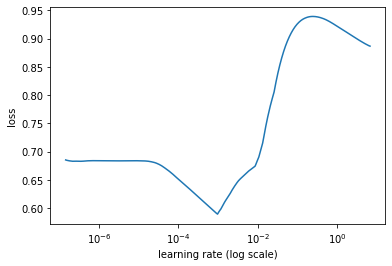

In [ ]:
learner.lr_find(show_plot=True, max_epochs= 2)

In [ ]:
learner.fit_onecycle(1e-4,3)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
250/250 [==============================] - 241s 965ms/step - loss: 0.3684 - accuracy: 0.8280 - val_loss: 0.2533 - val_accuracy: 0.8960
Epoch 2/3
250/250 [==============================] - 240s 959ms/step - loss: 0.2247 - accuracy: 0.9112 - val_loss: 0.2779 - val_accuracy: 0.8870
Epoch 3/3
250/250 [==============================] - 240s 960ms/step - loss: 0.1444 - accuracy: 0.9388 - val_loss: 0.2560 - val_accuracy: 0.8950


In [ ]:
learner.validate(class_names=['gender','race'])

              precision    recall  f1-score   support

      gender       0.89      0.84      0.87       401
        race       0.90      0.93      0.91       599

    accuracy                           0.90      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.90      0.89      1000



array([[337,  64],
       [ 41, 558]])

#### Predicting new value

In [ ]:
predictor = ktrain.get_predictor(learner.model,preproc=trans)

In [ ]:
x ="My psychologist is extremely intelligent." # testing professional bias

In [ ]:
predictor.predict(x)

'race'

In [ ]:
predictor.predict('black women are trashy.')

'race'

In [ ]:
predictor.predict('gay people are disgusting')

'gender'

In [ ]:
predictor.predict('having a criminal record is more attractive to her than having a phd a violent alpha male is the ultimate sexual desire for women ')

'gender'

In [ ]:
predictor.predict('another advantage of being a female getting by with your looks')

'gender'

In [ ]:
predictor.predict('if men are so privileged and women have it so hard why are so many men choosing to live as females ')

'gender'

Saving the model

In [ ]:
# predictor.save('distilBERT-model')

### Zero-shot-classification with huggingface transformer pipelines

In [ ]:
import tensorflow as tf
import torch as t

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-fd92ercw
  Running command git clone -q https://github.com/huggingface/transformers.git /tmp/pip-req-build-fd92ercw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for transformers: filename=transformers-4.1.0.dev0-cp36-none-any.whl size=1375102 sha256=f1361a553f6b46c7d906ef35c5e687283995b1432c61c6617c9bd1063cf3e49b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ra9wkxma/wheels/33/eb/3b/4bf5dd835e865e472d4fc0754f35ac0edb08fe852e8f21655f
Successfully built transformers


In [ ]:
import transformers

print("Transformers version", transformers.__version__)

In Transformers v4.0.0, the default path to cache downloaded models changed from '~/.cache/torch/transformers' to '~/.cache/huggingface/transformers'. Since you don't seem to have overridden and '~/.cache/torch/transformers' is a directory that exists, we're moving it to '~/.cache/huggingface/transformers' to avoid redownloading models you have already in the cache. You should only see this message once.


Transformers version 4.1.0.dev0


In [ ]:
from transformers import pipeline

zero_shot_classifier = pipeline('zero-shot-classification')

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification m

In [ ]:
input_text = ['My psychologist is extremely intelligent.']
candidate_labels = ['racial bias', 'gender bias','professional bias', 'cultural bias']

zero_shot_classifier(input_text,candidate_labels,multi_class=True)

{'labels': ['professional bias',
  'cultural bias',
  'gender bias',
  'racial bias'],
 'scores': [0.5417041182518005,
  0.11198366433382034,
  0.06356669962406158,
  0.03926229849457741],
 'sequence': 'My psychologist is extremely intelligent.'}

# Tasks To be done before coming meeting


*  Practical :

    1. Multi class classification - Doing
    2. Anti-stereotypical examples - Done
    3. Try other transformer models - Not Important
    4. Hyper-parameter tuning - Not Important **( Gather information)**
    5. Fine-tuning BERT for classification ( Tutorial : https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb) - **TBD**

* Theoritical :

    1. Clean-up proposal sections
      * Goals of thesis 
      * Tasks to be done w.r.t goal
    2. Q) In order to write 75 pages of thesis, I need to start with 
      * What is bias
      * Bias in data
      * Types of bias  
      * Social bias 

      ...
      **Write the technical background as well**





